In [ ]:
# Import library and API
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import random
import shutil
import sklearn
import pathlib 
import imageio
import cv2


from tensorflow.keras import models, layers, Model, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from google.colab import drive, files
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from PIL import Image

# Load Dataset

In [ ]:
# Mount file from Google Drive
drive.mount('/content/gdrive')

In [ ]:
# Unzip Dataset folder from Google Drive
!unzip gdrive/My\ Drive/Data/Data8020.zip

In [ ]:
# Create Train and Test Directory
base_dir = '/content/Data2/Data'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

Augment Image

In [ ]:
# Augment Image from Dataset

# Instantiate the ImageDataGenerator class
train_datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=60,
                                 shear_range=0.2,
                                 zoom_range=0.1,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

# Pass in the appropriate arguments to the flow_from_directory method
train_dataset = train_datagen.flow_from_directory(directory=train_dir,
                                                  batch_size=32,
                                                  target_size=(224, 224))

# Instantiate the ImageDataGenerator class
validation_datagen = ImageDataGenerator(rescale=1./255)

# Pass in the appropriate arguments to the flow_from_directory method
validation_dataset = validation_datagen.flow_from_directory(directory=test_dir,
                                                shuffle = False,
                                                batch_size=32,
                                                target_size=(224, 224))

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [ ]:
class_index = train_dataset.class_indices
print(class_index)

# Create and Train Model

In [ ]:
# Create Model
def create_model():
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224,224,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(5, activation='softmax')
      ]) 
    model.summary()


    model.compile(loss=losses.categorical_crossentropy,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    metrics=['accuracy']) 

    return model

In [ ]:
# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if (logs.get('accuracy') is not None and logs.get('accuracy') > 0.90):
#             print("\nReached 90% accuracy so cancelling training!")
#             self.model.stop_training = True
# # Instantiate class
# callbacks = myCallback()

In [ ]:
# Train Model
batch_size = 32
model = create_model()
EPOCHS = 150

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=validation_dataset)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 93312)             0         
                                                                 
 dense_5 (Dense)             (None, 128)              

# Model Performance

In [ ]:
# Determine for Accuracy and Loss parameter
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

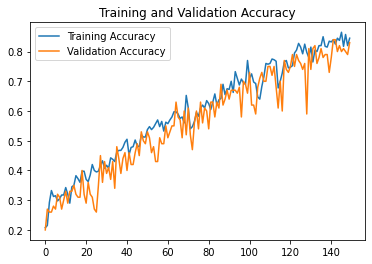

In [ ]:
# Plot Training and Validation Accuracy
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc=0)
plt.title('Training and Validation Accuracy')


Text(0.5, 1.0, 'Training and Validation Loss')

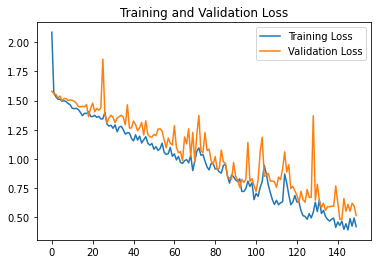

In [ ]:
# Plot Training and Validation Loss
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc=0)
plt.title('Training and Validation Loss')

In [ ]:
# Defining Evaluation Matrix for performance analysis
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat, average='macro')
    recall = recall_score(y, y_hat, average='macro')
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat, average='macro')
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();

Recall:  0.86
Accuracy:  0.86
Precision:  0.8814815775069859
F1:  0.8595128253730643


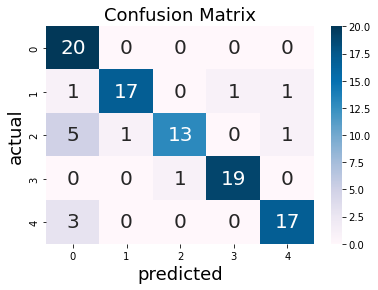

In [ ]:
# Show Confusion Matrix
y_predicted = model.predict(validation_dataset)
Y_pred = np.argmax(y_predicted, axis=1)

evaluation(validation_dataset.classes, Y_pred)

Model Testing

In [ ]:
# Test Model
uploaded = files.upload()

for fn in uploaded.keys():
  # Upload image
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  # Class probability list
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  temp = []
  temp = classes[0] 
  # print(temp)
  # print(np.argmax(temp)) 
  # print(fn)

  # Assing variable to dictionary
  key_list = list(class_index.keys())
  val_list = list(class_index.values())
 
  # Print prediction result
  position = val_list.index(np.argmax(temp))
  print(key_list[position])

Saving whitehead3.jpg to whitehead3.jpg
Saving whitehead2.jpg to whitehead2.jpg
Saving images.jpg to images.jpg
Saving cystic-acne-2.gif to cystic-acne-2.gif
Saving Rosacea_high.jpg to Rosacea_high.jpg
Saving rosacea.jpg to rosacea.jpg
Saving rosacea.png to rosacea.png
Saving blackhead2.jpg to blackhead2.jpg
Saving pustular.jpg to pustular.jpg
Saving blackhead.webp to blackhead.webp
Saving cystic.jpg to cystic.jpg
[0.23954359 0.2582071  0.10621546 0.04457247 0.35146135]
4
whitehead3.jpg
Whitehead
[0.9598404  0.0012473  0.0189744  0.01672488 0.00321301]
0
whitehead2.jpg
Blackhead
[0.70547354 0.21661761 0.0559998  0.01979878 0.00211018]
0
images.jpg
Blackhead
[9.3238550e-01 3.7269641e-02 1.2289684e-02 1.7595373e-02 4.5979352e-04]
0
cystic-acne-2.gif
Blackhead
[1.89583193e-06 4.18725517e-03 7.42597044e-01 2.53213733e-01
 1.01427894e-10]
2
Rosacea_high.jpg
Pustular
[9.2821974e-06 1.0802677e-03 5.6305110e-02 9.4259125e-01 1.4121813e-05]
3
rosacea.jpg
Rosacea
[7.30367184e-01 1.07349485e-01 2

# Save and Convert Model

In [ ]:
# # Save Model
# RPS_SAVED_MODEL = "rps_saved_model"
# tf.saved_model.save(model, RPS_SAVED_MODEL)

INFO:tensorflow:Assets written to: rps_saved_model/assets


In [ ]:
# %%bash -s $RPS_SAVED_MODEL
# saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['conv2d_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_conv2d_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_2'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 5)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
# loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [ ]:
# print(list(loaded.signatures.keys()))
# infer = loaded.signatures["serving_default"]
# print(infer.structured_input_signature)
# print(infer.structured_outputs)

['serving_default']
((), {'conv2d_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='conv2d_input')})
{'dense_2': TensorSpec(shape=(None, 5), dtype=tf.float32, name='dense_2')}


In [ ]:
# converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# tflite_model = converter.convert()

In [ ]:
# Save Model
export_dir = 'saved_model/1' 
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


In [ ]:
# Save to TFlite model file
tflite_model_file = 'modelconverted.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [ ]:
tflite_model_file = pathlib.Path("/content/model.tflite")
tflite_model_file.write_bytes(tflite_model)

47862944

# Interpreter

In [ ]:
# Define Interpreter for TFlite model test

def run_tflite_model(tflite_file, test_image):
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()
    print(interpreter.get_input_details())
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    print("mean", np.mean(output))
    print("std", np.std(output))
    prediction = output.argmax()

    return prediction

In [ ]:
# Test prediction in Interpreter
if __name__ == '__main__':
    converted_model = "/content/modelconverted.tflite"
    bad_image_path = "/content/Data2/Data/test/Cystic/acne-cystic-122.jpg"

    img = imageio.imread(bad_image_path)
    resized = cv2.resize(img, (224, 224)).astype('float32')
    resized = resized / 255.
    test_image = np.expand_dims(resized, axis=0)
    
    prediction = run_tflite_model(converted_model,test_image)
    print(prediction)

[{'name': 'serving_default_conv2d_4_input:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
mean 0.2
std 0.38942048
1
